In [ ]:
pip install transformers tensorflow


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     -------------------------------------- 48.7/48.7 kB 818.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/377.0 MB 5.1 MB/s eta 0:01:14
   ---------------------------------------- 0.1/377.0 MB 1.2 MB/s eta 0:05:24
   ---------------------------------------- 0.1/377.0 MB 1.2 MB/s eta 0:05:24
   ---------------------------------------- 0.1/377.0 MB 1.2 MB/s eta 0:05:24
   ---------------------------------------- 0.2/377.0 MB 1.0 MB/s eta 0:06:07
   ---------------------------------------- 0.3/377.0 MB 923.9 kB/s eta 0:06:48
   ---------------------------------------- 0.3/377.0 MB 923.9 kB/s eta 0:06:48
   ---------------------------------------- 0.3/377.0 MB 923.9 kB/s eta 0:06:48
   ---------------------------------------- 0

In [47]:
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [35]:
articles_df = pd.read_csv('green_energy_articles_max_articles_end20220101.csv')
articles_df['Time'] = pd.to_datetime(articles_df['Time'], format='%d %b, %Y, %I:%M %p IST')
articles_df['Date'] = articles_df['Time'].dt.date

print(articles_df.shape)
articles_df.head()

(1254, 5)


,Title,Link,Description,Time,Date
0,"NexGen Energia plans to invest Rs 15,000 cr ov...",https://economictimes.indiatimes.com/industry/...,"NexGen Energia plans a Rs 15,000 crore investm...",2024-07-07 13:52:00,2024-07-07
1,JSW Energy plans ₹1.15 L cr capex to diversify...,https://economictimes.indiatimes.com/industry/...,JSW Energy announces a strategic shift towards...,2024-07-06 00:35:00,2024-07-06
2,Interest subvention likely to push energy effi...,https://economictimes.indiatimes.com/industry/...,The power ministry has begun discussions on of...,2024-07-05 23:45:00,2024-07-05
3,MNRE issues incentive guidelines for green hyd...,https://economictimes.indiatimes.com/industry/...,Solar Energy Corporation of India (SECI) is th...,2024-07-05 17:29:00,2024-07-05
4,Norms issued for funding of testing facilities...,https://economictimes.indiatimes.com/industry/...,The Ministry of New and Renewable Energy has r...,2024-07-05 00:41:00,2024-07-05


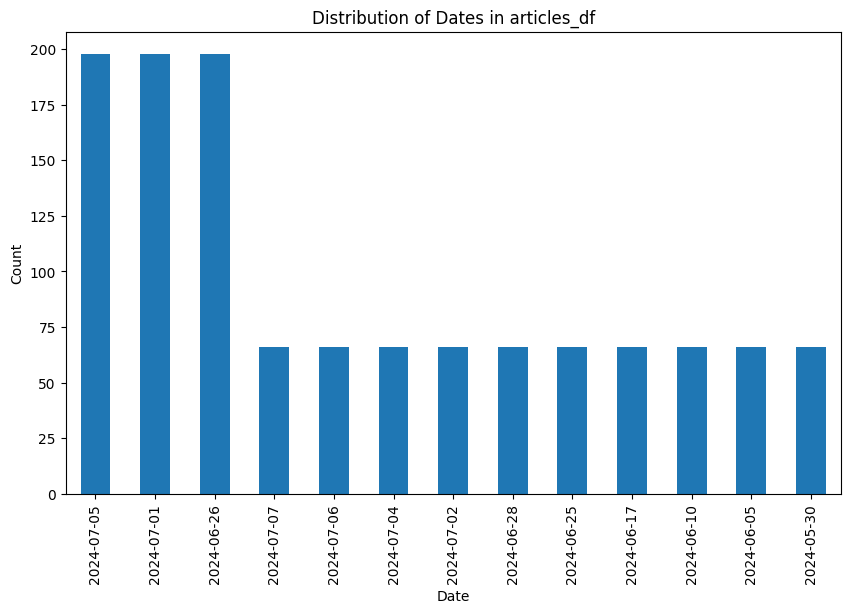

In [23]:
import matplotlib.pyplot as plt

# Count the occurrences of each date
date_counts = articles_df['Date'].value_counts()

# Plot the distribution of dates
plt.figure(figsize=(10, 6))
date_counts.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Dates in articles_df')
plt.show()

In [31]:
prices_df = pd.read_csv('stock_prices.csv')
# Convert prices date to datetime format and extract the date
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date

print(prices_df.shape)
prices_df.head()

(1258, 5)


,Date,Close/Last,Open,High,Low
0,2024-07-05,465.0758,468.9903,469.9370,461.9273
1,2024-07-03,467.0909,457.3616,469.8444,456.4637
2,2024-07-02,452.6402,447.1168,455.2006,446.3567
3,2024-07-01,443.2176,446.6093,448.5056,442.4779
4,2024-06-28,445.4215,459.4902,461.6365,442.0227


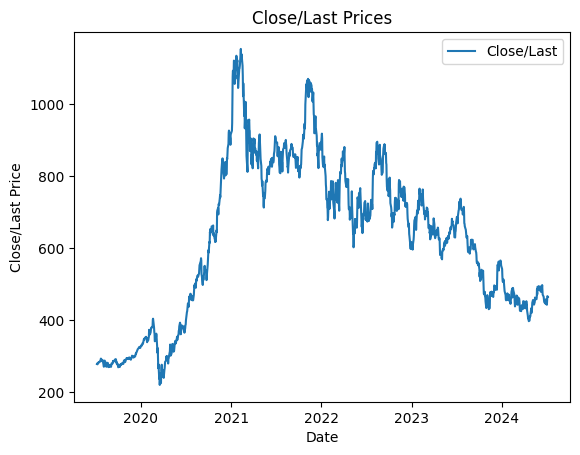

In [36]:
prices_df.plot(x='Date', y='Close/Last', kind='line')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.title('Close/Last Prices')
plt.show()

Align Articles with Stock Prices and Aggregate Articles


In [20]:

# Merge articles with prices_df on date
merged_df = pd.merge(prices_df, articles_df, on='Date', how='left')

# Aggregate articles by date
aggregated_articles = merged_df.groupby('Date').agg({
    'Title': lambda x: ' '.join(x.dropna()),
    'Description': lambda x: ' '.join(x.dropna())
}).reset_index()

# Merge aggregated articles back with prices_df
final_df = pd.merge(prices_df, aggregated_articles, on='Date', how='left')
final_df.head()

,Date,Close/Last,Open,High,Low,Title,Description
0,2024-07-05,465.0758,468.9903,469.9370,461.9273,Interest subvention likely to push energy effi...,The power ministry has begun discussions on of...
1,2024-07-03,467.0909,457.3616,469.8444,456.4637,,
2,2024-07-02,452.6402,447.1168,455.2006,446.3567,World’s most volatile big stock is rocking Ind...,Indonesia's stock market faces turmoil as PT B...
3,2024-07-01,443.2176,446.6093,448.5056,442.4779,"AM Green, SJVN arm ink MoU for supply and sour...",AM Green's partnership with SJVN Green Energy ...
4,2024-06-28,445.4215,459.4902,461.6365,442.0227,Hero Future Energies gets shortlisted for Bhub...,"Hero Future Energies (HFE), the renewable ener..."


Step 5: Extract Features from the Text


In [ ]:
# Fill missing text data with an empty string
final_df['Title'] = final_df['Title'].fillna('')
final_df['Description'] = final_df['Description'].fillna('')

# Combine Title and Description into one text feature
final_df['Text'] = final_df['Title'] + ' ' + final_df['Description']
final_df = final_df.drop(columns=['Title', 'Description'])  # Drop individual text columns if not needed

In [28]:
# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize the text data
def encode_texts(texts, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',  # Updated padding argument
            truncation=True,  # Added truncation argument
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

# Encode texts
input_ids, attention_masks = encode_texts(final_df['Text'], tokenizer, max_length=128)

# Get BERT embeddings
def get_bert_embeddings(input_ids, attention_masks, bert_model):
    embeddings = bert_model(input_ids=input_ids, attention_mask=attention_masks)[0]
    return embeddings[:, 0, :].numpy()  # Use the CLS token embedding

embeddings = get_bert_embeddings(input_ids, attention_masks, bert_model)

# Combine BERT embeddings with numerical features
X = np.concatenate([embeddings, final_df.drop(columns=['Date', 'Title', 'Description', 'Text']).values], axis=1)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

 Prepare the Target Variable

In [38]:
# Prepare the target variable
final_df['Target'] = (final_df['Close/Last'].shift(-1) > final_df['Close/Last']).astype(int)
X = X[:-1]
y = final_df['Target'].iloc[:-1]

In [45]:
final_df['Target'].value_counts(normalize=True)


Target
0    0.523847
1    0.476153
Name: proportion, dtype: float64

Train a Logistic Regression Model

In [22]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import StandardScaler

# # Scale the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Train the model
# model = LogisticRegression(max_iter=100, solver='lbfgs')
# model.fit(X_train, y_train)

# # Make predictions
# y_pred = model.predict(X_test)

# # Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5


Train a LSTM Model

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - accuracy: 0.4997 - loss: 0.6916 - val_accuracy: 0.7262 - val_loss: 0.6490
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.6954 - loss: 0.6401 - val_accuracy: 0.7619 - val_loss: 0.5688
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.8083 - loss: 0.5495 - val_accuracy: 1.0000 - val_loss: 0.3987
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.8940 - loss: 0.3990 - val_accuracy: 1.0000 - val_loss: 0.2599
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.8923 - loss: 0.3001 - val_accuracy: 1.0000 - val_loss: 0.1743
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - accuracy: 0.9041 - loss: 0.2362 - val_accuracy: 1.0000 - val_loss: 0.1250
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 311ms/step - accuracy: 0.8841 - loss: 0.2252 - val_accuracy: 1.0000 - val_loss: 0.0932
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 311ms/step - accuracy: 0.8879 - loss: 0.1939 - val_accuracy:

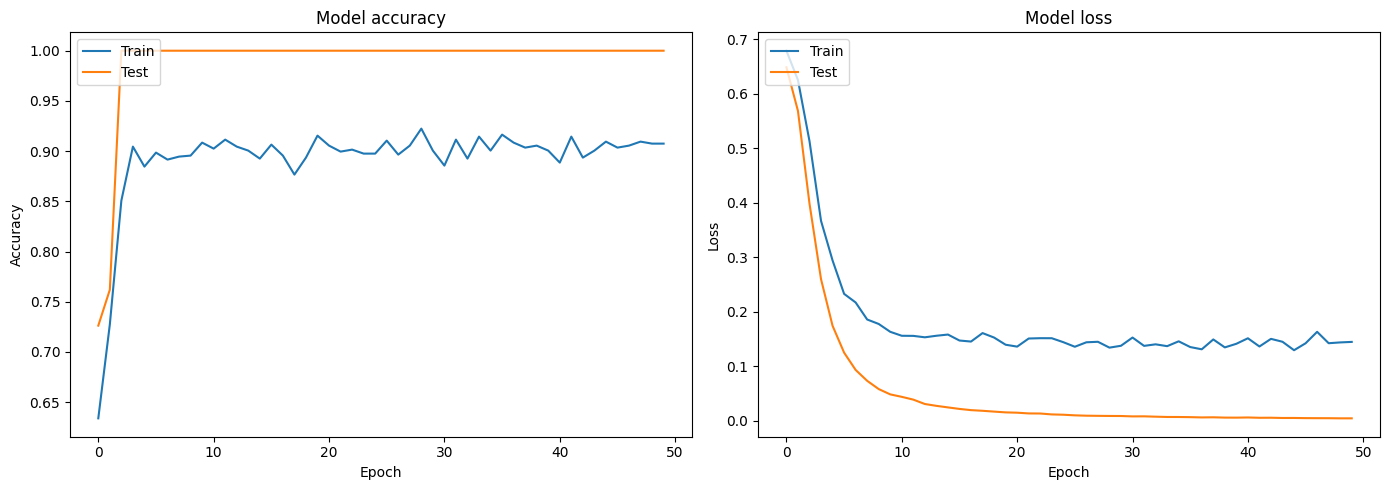

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Accuracy: 1.0


In [48]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Reshape((X_train.shape[1], 1)),
    tf.keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2),  # Adding dropout
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model and capture history
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot the learning curves
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Assuming you have the true labels in y_true and the predicted labels in y_pred
cm = confusion_matrix(y, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()